This is a follow-up from last week's implementation of GP. There are two milestones in this experiment:

1. Optimize the loglikelihood to get optimum kernel parameter

1. Create a prediction pipeline to save time writing script for every experiment

# Optimum Loglikelihood

**Question** Last week you said to me to create a table which shows the parameter and indicate which parameter has the highest loglikehood. I suppose that is some form of a grid search validation, where we train the GP with several combination of kernel parameters ($\lambda, \sigma$), just like in SVM. But unlike SVM, the performance of GP is measured by loglikehood which has the following equation

$$
LL = - \frac{1}{2} y^T C^{-1} y - \frac{1}{2} log \det C - \frac{n}{2} log 2\pi
$$

where $C = K + \sigma^2 I$. My understanding is that we can directly optimize the parameter my maximize the loglikelihood (or minimize the negative LL), so actually the grid search is unnecessary. So, is my interpretation is correct? Or grid search is still neccessary for some other reason (control overfitting?)?

Based on the above argument, I try to optimize the parameter by composing an minimization problem where the objective function is the *negative* loglikehood

\begin{equation*}
\begin{aligned}
& \underset{\lambda, \sigma}{\text{minimize}} 
&& \frac{1}{2} y^T C^{-1} y + \frac{1}{2} \log \det C + \frac{n}{2} log 2\pi \\
& \text{subject to}
&& \lambda > 0 \\
&
&& \sigma > 0
\end{aligned}
\end{equation*}

and using the build-in optimization solver that python (or MATLAB) offers.

Directly writing the LL equation using `det` and `inv` is highly inefficient since it is slow and very unstable (Singular Matrix error). We can optimize the code by knowing that the covariance matrix is a positive definite matrix (well, in theory) by using Cholesky Decomposition

\begin{align*}
C &= LL^T \\
C^{-1} &= (L^{-1})^{T} L^{-1}
\end{align*}

and so we can simplify the the inverse part of the loglikehood equation to

\begin{align*}
\frac{1}{2} y^T C^{-1} y &= \frac{1}{2} y^T (L^{-1})^{T} L^{-1} y \\
&= \frac{1}{2} y^T (L^{T})^{-1} (L^{-1} y)
\end{align*}

where we can solve the $(L^{T})^{-1} (L^{-1} y)$ using backslash operator in MATLAB or `np.linalg.solve` in Python so the equation becomes

\begin{align*}
\frac{1}{2} y^T C^{-1} y &= \frac{1}{2} y^T L^{T} \setminus (L \setminus y)
\end{align*}

Similarly, the determinant part of the LL equation can also be simplified greatly knowing the fact that the determinant of a triangular matrix is a product of its diagonal elements, so

\begin{align*}
\frac{1}{2} log \det C &= log \det LL^T \\
&= \log \det L \det L^T \\
&= \log \prod_{i=1}^{n} L_{ii}^2
\end{align*}

The Loglikehood function now becomes
$$
LL = - \frac{1}{2} y^T L^{T} \setminus (L \setminus y) - \frac{1}{2} \log \prod_{i=1}^{n} L_{ii}^2 - \frac{n}{2} log 2\pi
$$

**Question** Using Cholesky decomposition makes the algorithm runs faster, but still my implementation breaks easily because the covariance matrix becomes non positive definite and sometimes the diagonal elements turns to complex number. The correction or regularization matrix $\sigma I$ is a way to incorporate noise into the GP model and it also helps stabilize the algorithm. My question is now how can we determine the regularization matrix from the data? I watch a lecture on GP and the presenter said 'the noise can be determined easily from the data' yet I find that it is not a trivial problem to find the noise since indeed like you said that finding a noise is a chicken and egg problem.

# Pipeline

To make the experiment easier, I design a machine learning pipeline which is shown in below figure

![pipeline](pipeline.png)

Now I should demonstrate the working combination of the parameter optimization and the pipeline

## Simple Regression

In [5]:
from thesis import data
from thesis import pipeline
from thesis import gp
from thesis import evaluation
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import MinMaxScaler

style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

      fun: -4.7756537876621223
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.10542736e-06,   4.26325641e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 9
   status: 0
  success: True
        x: array([ 3.165852  ,  1.04570941])


[('mean_square_error', 0.041107003890995711),
 ('mean_absolute_error', 0.16264093600375792),
 ('median_absolute_error', 0.13590249604393373)]

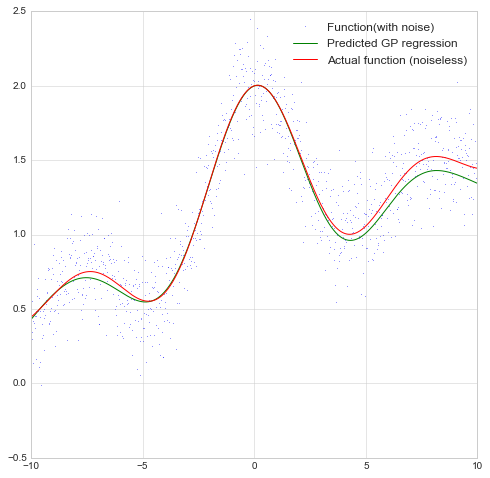

In [8]:
p = pipeline.Pipeline(
    data=data.SinData(),
    transformer=None,
    predictor=gp.GaussianProcess(correction=0.2),
    evaluator=[evaluation.mean_square_error,
               evaluation.mean_absolute_error,
               evaluation.median_absolute_error]
)

p.start()

plt.figure(1)
plt.plot(p.data.x_test,p.data.y_test, '.', ms=0.5)
plt.plot(p.data.x_test,p.y_pred[0])
plt.plot(p.data.x_test,p.data.y_true)
plt.legend(('Function(with noise)', 'Predicted GP regression', 'Actual function (noiseless)'))

p.error

## Wind Speed Regression

      fun: 0.14305177927681711
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.16738682,  0.41556518])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 10
   status: 0
  success: True
        x: array([ 1.95841322,  2.00070626])


/Users/bagas/anaconda/envs/thesis2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,32) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


[('mean_square_error', 0.31414170434903305),
 ('mean_absolute_error', 0.29353593259706146),
 ('median_absolute_error', 0.1285804499313038)]

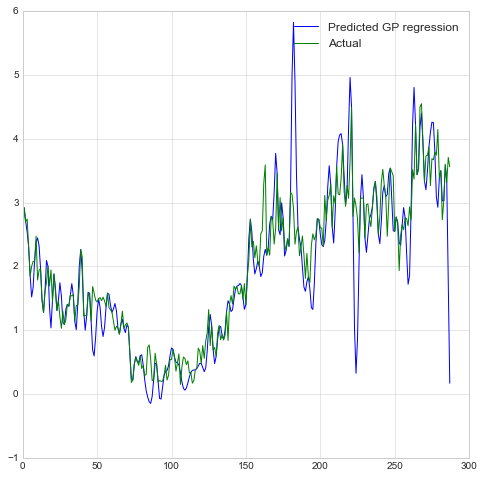

In [44]:
p = pipeline.Pipeline(
    data=data.WindDataRandom('2016/1/1'),
    transformer=None,
    predictor=gp.GaussianProcess(correction=10e-4),
    evaluator=[evaluation.mean_square_error,
               evaluation.mean_absolute_error,
               evaluation.median_absolute_error])

p.start()

plt.figure()
plt.plot(p.data.x_test,p.y_pred[0])
plt.plot(p.data.x_test,p.data.y_test)
plt.legend(('Predicted GP regression', 'Actual'))

p.error

## Wind Data Regression

Like before, the goal is given seven days worth of wind speed data, the GP tries to forecast the wind speed for the next whole day.

/Users/bagas/anaconda/envs/thesis2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,32) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/Users/bagas/anaconda/envs/thesis2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/bagas/anaconda/envs/thesis2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/bagas/anaconda/envs/thesis2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passi

      fun: 2219.9195464190939
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.37287002e+03,   3.63797881e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 11
   status: 0
  success: True
        x: array([  0.1       ,  26.52121911])


[('mean_square_error', 20.105232505205375),
 ('mean_absolute_error', 3.1687602079341723),
 ('median_absolute_error', 2.3359999999999999)]

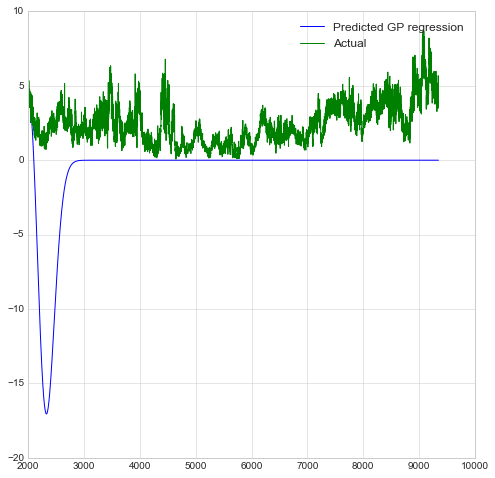

In [41]:
p = pipeline.Pipeline(
    data=data.WindData('2016/1/1', '2016/1/7', '2016/1/8', None),
    transformer=[MinMaxScaler()],
    predictor=gp.GaussianProcess(correction=10e-1),
    evaluator=[evaluation.mean_square_error,
               evaluation.mean_absolute_error,
               evaluation.median_absolute_error]
)

p.start()

plt.figure(1)
plt.plot(p.data.x_test,p.y_pred[0])
plt.plot(p.data.x_test,p.data.y_test)
plt.legend(['Predicted GP regression', 'Actual'])

p.error

**Question** How people usually interpret regression error? Since the error is not as intuitive as classification?

# To-do

Again, the prediction result is very unsatisfactory, even when the parameter is optimized according to the solver. List of things to do:

* Making the prediction work with GP

* After that, I should try using multivariate data on the prediction. **Question** When using univariate data, the feature is simply the time step. In multivariate data, do you think the time step is a neccessary feature? Since time step is deterministic.

* Trying out the RNN-LSTM

* Read some basics on Time Series Analysis
